In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
from pydub import AudioSegment
import warnings
warnings.filterwarnings('ignore')
import joblib

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report,confusion_matrix, multilabel_confusion_matrix

In [3]:
directory_path = 'DATA_SET'

In [4]:
def convert_m4a_to_wav(mp3_path):
    wav_path = mp3_path.replace('.mp3', '.wav')
    audio = AudioSegment.from_file(mp3_path, format="mp3")
    audio.export(wav_path, format="wav")
    return wav_path

In [5]:
paths = []
labels = []

if os.path.exists(directory_path):
    for dirname, _, filenames in os.walk(directory_path):
        for filename in filenames:
            file_path = os.path.join(dirname, filename)
            wav_file_path =convert_m4a_to_wav(file_path)
            category = os.path.basename(dirname)  
            paths.append(wav_file_path)
            labels.append(category)

    print(f'Dataset Loaded: {len(paths)} files found.')


    df = pd.DataFrame({'file_path': paths, 'label': labels})
else:
    print('Directory does not exist.')


Dataset Loaded: 232 files found.


In [6]:
df.tail(10)

,file_path,label
222,DATA_SET\Substitution\S5.wav,Substitution
223,DATA_SET\Substitution\S5.wav,Substitution
224,DATA_SET\Substitution\S6.wav,Substitution
225,DATA_SET\Substitution\S6.wav,Substitution
226,DATA_SET\Substitution\S7.wav,Substitution
227,DATA_SET\Substitution\S7.wav,Substitution
228,DATA_SET\Substitution\S8.wav,Substitution
229,DATA_SET\Substitution\S8.wav,Substitution
230,DATA_SET\Substitution\S9.wav,Substitution
231,DATA_SET\Substitution\S9.wav,Substitution


In [7]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

<Axes: xlabel='label', ylabel='count'>

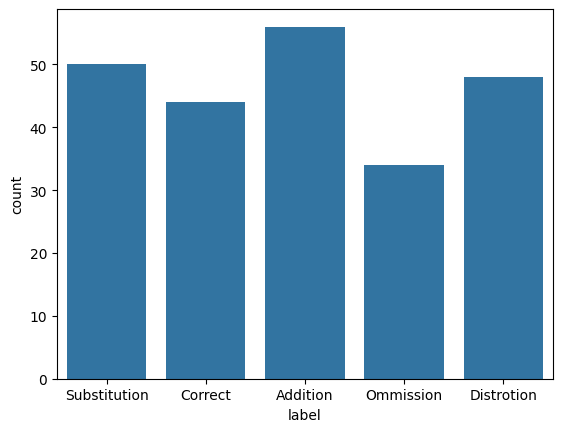

In [8]:
sns.countplot(data=df, x='label')

In [9]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()
    
def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

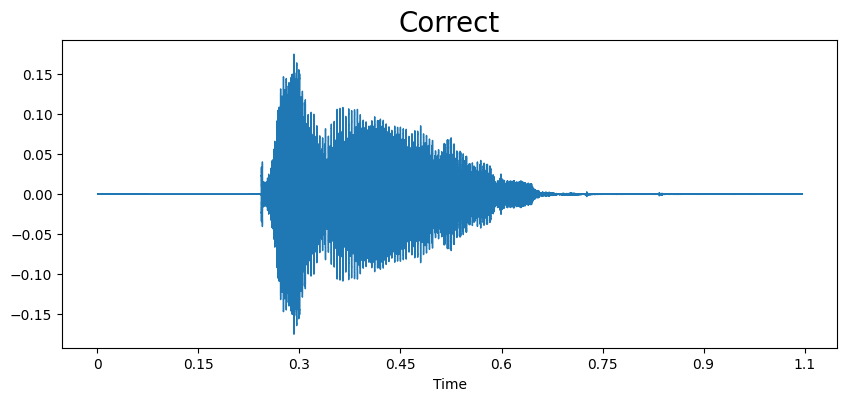

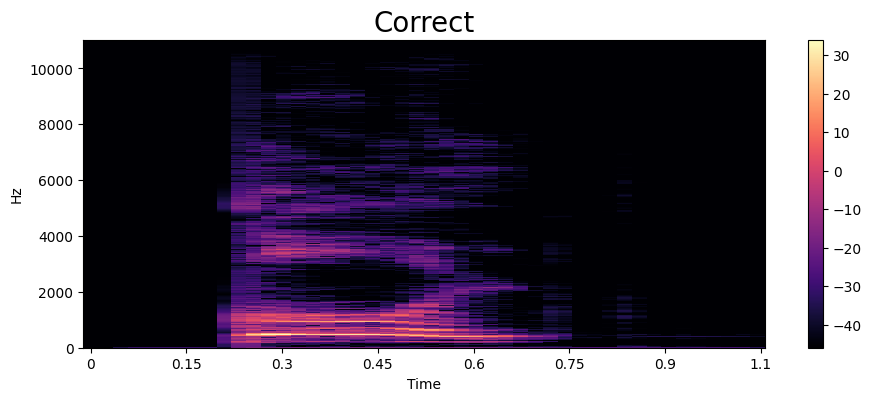

In [10]:
emotion = 'Correct'
path = np.array(df['file_path'][df['label']==emotion])[5]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

In [11]:
def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    return mfcc

In [70]:
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC

In [71]:
processor_from_facebook = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model_from_facebook = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [73]:
def recognize_phonemes(audio_path):
    audio_input, _ = librosa.load(audio_path, sr=16000)

    input_values = processor_from_facebook(audio_input, return_tensors="pt", sampling_rate=16000).input_values
    
    with torch.no_grad():
        logits = model_from_facebook(input_values).logits
        predicted_ids = torch.argmax(logits, dim=-1)
        transcription = processor_from_facebook.batch_decode(predicted_ids)[0]
    
    return transcription

In [82]:
phonemes=recognize_phonemes(np.array(df['file_path'][df['label']=="Correct"])[5])
phonemes

'GOD'

In [75]:
letters = list(phonemes.lower())

In [76]:
letters

['g', 'o', 'd']

In [77]:
target_sounds = ['m', 'n', 'k', 'g', 'f', 'ch', 'j', 'l', 'h']

In [78]:
problematic_sounds = [1 if sound in letters else 0 for sound in target_sounds]

In [79]:
problematic_sounds

[0, 0, 0, 1, 0, 0, 0, 0, 0]

In [ ]:
def extract_mfcc(filename):

    phonemes=recognize_phonemes(filename)
    letters = list(phonemes.lower())
    
    target_sounds = ['m', 'n', 'k', 'g', 'f', 'ch', 'j', 'l', 'h']

    problematic_sounds = [1 if sound in letters else 0 for sound in target_sounds]

    problematic_sounds = np.array(problematic_sounds)

    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=31).T, axis=0)

    result = np.concatenate((mfcc, problematic_sounds))
    return result

In [ ]:
extract_mfcc(df['file_path'][0])

array([-4.29719025e+02,  5.41063461e+01,  2.43071055e+00,  1.25321045e+01,
       -1.87910807e+00, -1.81123791e+01, -1.38636694e+01, -1.79593163e+01,
       -2.09286270e+01, -5.53486586e+00, -3.47193813e+00,  3.31347895e+00,
        1.91320753e+00,  7.50252533e+00,  9.42663097e+00,  8.24239731e+00,
        6.71422768e+00,  3.34505773e+00,  3.51828766e+00, -2.03704858e+00,
       -1.09168708e+00, -2.29939246e+00, -7.03333139e+00, -2.27557731e+00,
       -3.94444823e+00,  3.59721780e-01,  5.34445333e+00,  6.48400736e+00,
        3.92716670e+00,  7.64372647e-01, -2.30878901e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [13]:
X_mfcc = df['file_path'].apply(lambda x: extract_mfcc(x))

In [14]:
type(X_mfcc)

pandas.core.series.Series

In [15]:
X_mfcc[0:3]

0    [-429.71902, 54.106346, 2.4307106, 12.5321045,...
1    [-548.91077, 68.56391, 19.646515, -23.585217, ...
2    [-399.8318, 52.602226, -2.746141, 0.7358344, -...
Name: file_path, dtype: object

In [16]:
X_mfcc.shape

(232,)

In [17]:
X = [x for x in X_mfcc]
X = np.array(X)
X.shape

(232, 40)

In [18]:
X[0]

array([-4.29719025e+02,  5.41063461e+01,  2.43071055e+00,  1.25321045e+01,
       -1.87910807e+00, -1.81123791e+01, -1.38636694e+01, -1.79593163e+01,
       -2.09286270e+01, -5.53486586e+00, -3.47193813e+00,  3.31347895e+00,
        1.91320753e+00,  7.50252533e+00,  9.42663097e+00,  8.24239731e+00,
        6.71422768e+00,  3.34505773e+00,  3.51828766e+00, -2.03704858e+00,
       -1.09168708e+00, -2.29939246e+00, -7.03333139e+00, -2.27557731e+00,
       -3.94444823e+00,  3.59721780e-01,  5.34445333e+00,  6.48400736e+00,
        3.92716670e+00,  7.64372647e-01, -2.30878901e+00,  5.42577982e+00,
        5.16097927e+00,  5.96953249e+00,  5.83307457e+00,  3.39599228e+00,
        4.03615999e+00,  3.28236008e+00,  3.52947545e+00,  7.69883513e-01],
      dtype=float32)

In [19]:
X = np.expand_dims(X, -1)
X.shape

(232, 40, 1)

In [20]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(df[["label"]])

In [21]:
joblib.dump(enc, 'encoder.pkl')

['encoder.pkl']

In [22]:
y = y.toarray()

In [23]:
y

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]])

In [24]:
y.shape

(232, 5)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
model = Sequential()

model.add(LSTM(256, return_sequences=False, input_shape=(40, 1)))
model.add(Dropout(0.2))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))


In [27]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 256)            │       264,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 305,669 (1.17 MB)

 Trainable params: 305,669 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
X_train.shape, y_train.shape

((185, 40, 1), (185, 5))

In [29]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=15, restore_best_weights=True)

In [30]:
y_train.shape

(185, 5)

In [31]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=64, callbacks=[early_stop])

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 727ms/step - accuracy: 0.1898 - loss: 1.6008 - val_accuracy: 0.2766 - val_loss: 1.5675
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.2606 - loss: 1.5418 - val_accuracy: 0.2979 - val_loss: 1.5250
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.3585 - loss: 1.4846 - val_accuracy: 0.3617 - val_loss: 1.4673
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step - accuracy: 0.3869 - loss: 1.4257 - val_accuracy: 0.3617 - val_loss: 1.4254
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.3982 - loss: 1.3774 - val_accuracy: 0.3830 - val_loss: 1.4220
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.4042 - loss: 1.3693 - val_accuracy: 0.3830 - val_loss: 1.4401
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step - accuracy: 0.3958 - loss: 1.3384 - val_accuracy: 0.2979 - val_loss: 1.4374
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.3992 - loss: 1.3372 - val_accuracy: 0.4255 - 

In [ ]:
# model.save('first_model.h5')

In [32]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

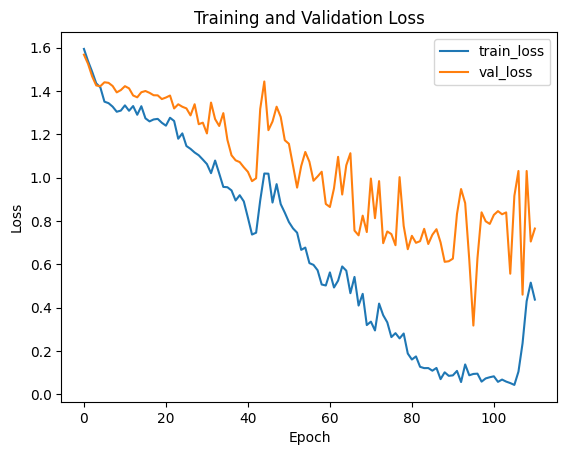

In [33]:
plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [34]:
predictions = model.predict(X_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


In [35]:
predictions = predictions.round()

In [36]:
predictions


array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0.

In [37]:
y_val

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0.

In [38]:
print(classification_report(y_val,predictions))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       1.00      0.89      0.94         9
           2       0.67      1.00      0.80         8
           3       1.00      1.00      1.00         6
           4       1.00      1.00      1.00        12

   micro avg       0.91      0.91      0.91        47
   macro avg       0.93      0.93      0.92        47
weighted avg       0.94      0.91      0.92        47
 samples avg       0.91      0.91      0.91        47



In [39]:
cm_matrices = multilabel_confusion_matrix(y_val, predictions)
cm_matrices

array([[[35,  0],
        [ 3,  9]],

       [[38,  0],
        [ 1,  8]],

       [[35,  4],
        [ 0,  8]],

       [[41,  0],
        [ 0,  6]],

       [[35,  0],
        [ 0, 12]]])

In [40]:
def plot_multilabel_confusion_matrices(y_true, y_pred, classes):

    cm_matrices = multilabel_confusion_matrix(y_true, y_pred)
    num_classes = len(classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(num_classes * 4, 4))
    
    if num_classes == 1:
        axes = [axes]  
    
    for i, cm in enumerate(cm_matrices):
        ax = axes[i]
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"], ax=ax)
        ax.set_title(classes[i])
        ax.set_xlabel("Predicted Label")
        ax.set_ylabel("True Label")
    
    plt.tight_layout()
    plt.show()

In [41]:
classes = ["addition", "correct", "distrotion", "ommission", "substitution"]

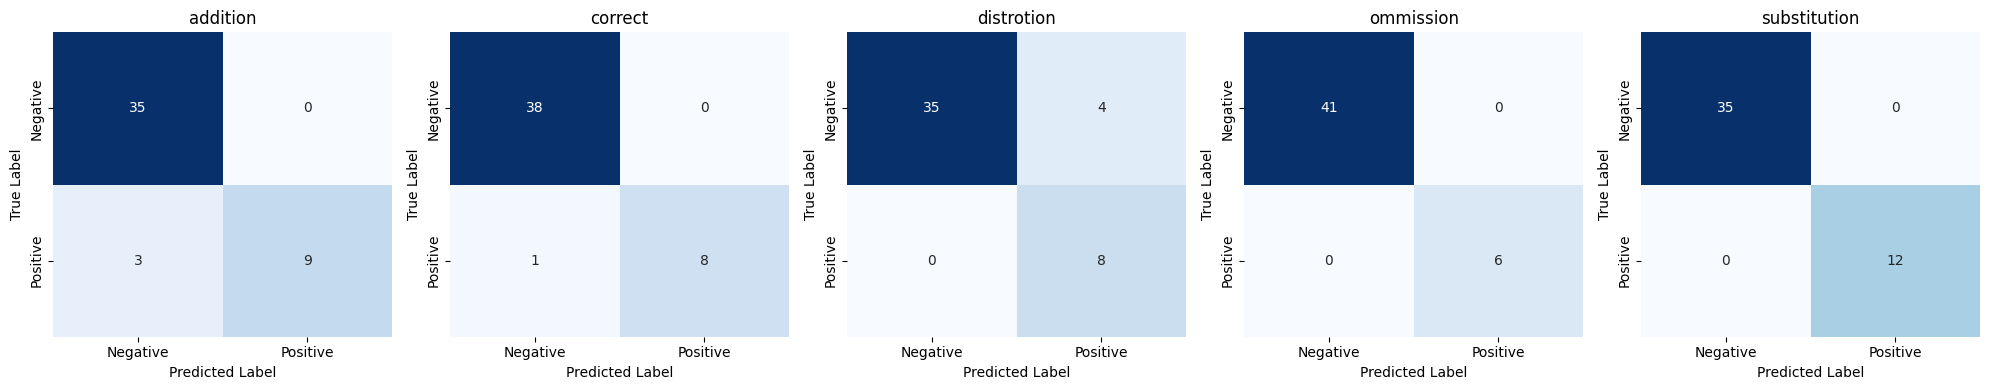

In [42]:
plot_multilabel_confusion_matrices(y_val, predictions, classes)

In [43]:
def plot_confusion_matrix1(y_true, y_pred, classes):

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()



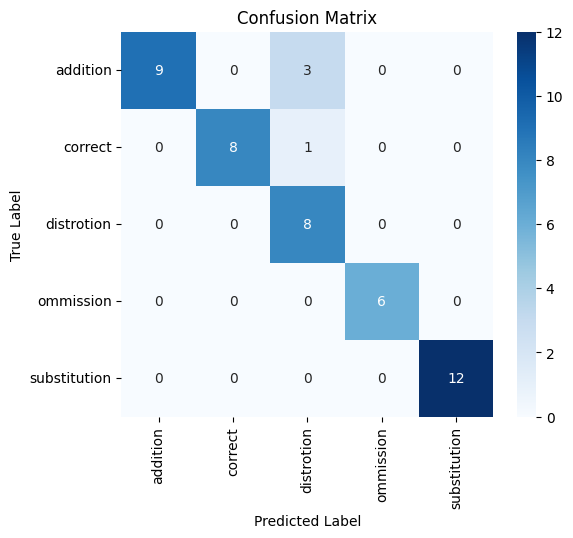

In [44]:
plot_confusion_matrix1(np.argmax(y_val, axis=1), np.argmax(predictions, axis=1), classes)

### Hyperparameter Tuning

In [ ]:
def build_model(hp):
    model = Sequential()
    
    
    model.add(LSTM(hp.Int('lstm_units', min_value=64, max_value=512, step=64), 
                   return_sequences=False, input_shape=(40, 1)))
    model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

    
    model.add(Dense(hp.Int('dense_units1', 64, 256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout2', 0.1, 0.5, step=0.1)))

    model.add(Dense(hp.Int('dense_units2', 32, 128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout3', 0.1, 0.5, step=0.1)))

    
    model.add(Dense(5, activation='softmax'))

    
    lr = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])
    
    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  
    executions_per_trial=2,  
    directory='hyperparam_tuning',
    project_name='lstm_tuning'
)

In [48]:
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

Trial 10 Complete [00h 03m 39s]
val_accuracy: 0.6063829660415649

Best val_accuracy So Far: 0.8085106611251831
Total elapsed time: 00h 20m 29s


In [49]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best LSTM Units: {best_hps.get('lstm_units')}")
print(f"Best Dense Layer 1 Units: {best_hps.get('dense_units1')}")
print(f"Best Dense Layer 2 Units: {best_hps.get('dense_units2')}")
print(f"Best Dropout Rates: {best_hps.get('dropout1')}, {best_hps.get('dropout2')}, {best_hps.get('dropout3')}")
print(f"Best Learning Rate: {best_hps.get('learning_rate')}")

Best LSTM Units: 448
Best Dense Layer 1 Units: 64
Best Dense Layer 2 Units: 64
Best Dropout Rates: 0.2, 0.1, 0.1
Best Learning Rate: 0.001


In [50]:
best_model = tuner.hypermodel.build(best_hps)

In [51]:
history_best_model = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=32, callbacks=[early_stop])

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 350ms/step - accuracy: 0.2920 - loss: 1.5888 - val_accuracy: 0.3404 - val_loss: 1.5095
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.3466 - loss: 1.4655 - val_accuracy: 0.3404 - val_loss: 1.4678
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.2458 - loss: 1.4622 - val_accuracy: 0.3191 - val_loss: 1.5028
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step - accuracy: 0.2538 - loss: 1.4733 - val_accuracy: 0.3830 - val_loss: 1.5012
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 289ms/step - accuracy: 0.4111 - loss: 1.3919 - val_accuracy: 0.3404 - val_loss: 1.7734
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.4347 - loss: 1.3777 - val_accuracy: 0.4255 - val_loss: 1.4182
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.4465 - loss: 1.2798 - val_accuracy: 0.4255 - val_loss: 1.4144
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.4430 - loss: 1.2657 - val_accuracy: 0.4468 - v

In [88]:
predictions_best_model = best_model.predict(X_val).round()

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 207ms/step


In [89]:
print(classification_report(y_val,predictions_best_model))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       1.00      1.00      1.00         9
           2       0.80      1.00      0.89         8
           3       1.00      0.83      0.91         6
           4       1.00      1.00      1.00        12

   micro avg       0.96      0.91      0.93        47
   macro avg       0.96      0.92      0.93        47
weighted avg       0.97      0.91      0.93        47
 samples avg       0.91      0.91      0.91        47



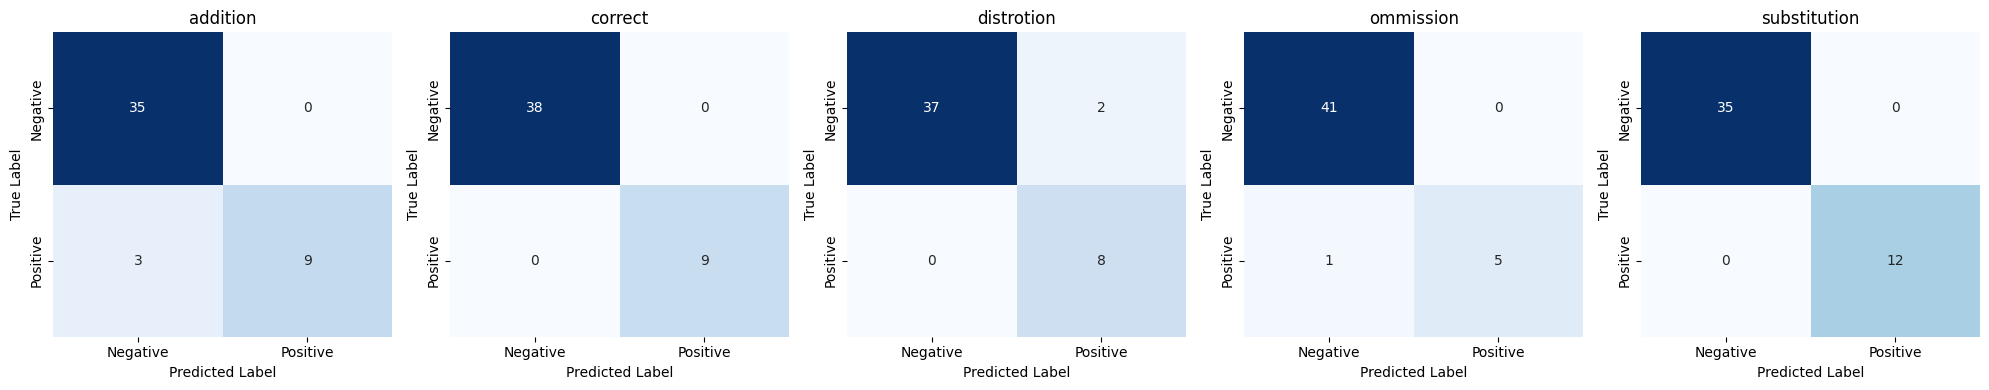

In [90]:
plot_multilabel_confusion_matrices(y_val, predictions_best_model, classes)

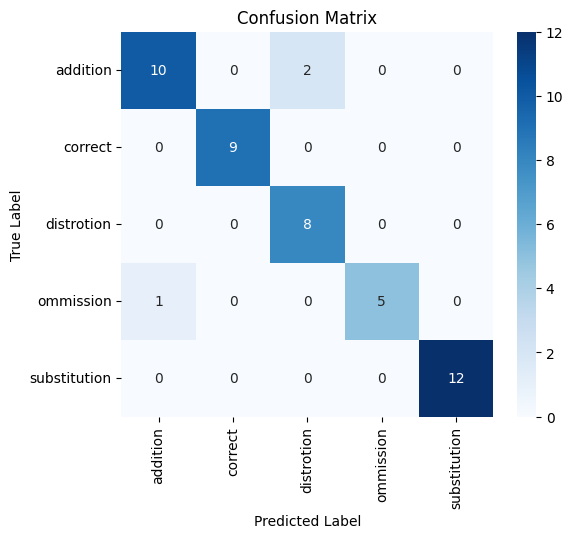

In [91]:
plot_confusion_matrix1(np.argmax(y_val, axis=1), np.argmax(predictions_best_model, axis=1), classes)

In [ ]:
# best_model.save('best_model.h5')

In [94]:
from tensorflow.keras.models import load_model

In [95]:
final_model = load_model("best_model.h5")

In [57]:
test = extract_mfcc(df['file_path'][0])

In [58]:
test = [x for x in test]
test = np.array(test)

In [59]:
test

array([-4.29719025e+02,  5.41063461e+01,  2.43071055e+00,  1.25321045e+01,
       -1.87910807e+00, -1.81123791e+01, -1.38636694e+01, -1.79593163e+01,
       -2.09286270e+01, -5.53486586e+00, -3.47193813e+00,  3.31347895e+00,
        1.91320753e+00,  7.50252533e+00,  9.42663097e+00,  8.24239731e+00,
        6.71422768e+00,  3.34505773e+00,  3.51828766e+00, -2.03704858e+00,
       -1.09168708e+00, -2.29939246e+00, -7.03333139e+00, -2.27557731e+00,
       -3.94444823e+00,  3.59721780e-01,  5.34445333e+00,  6.48400736e+00,
        3.92716670e+00,  7.64372647e-01, -2.30878901e+00,  5.42577982e+00,
        5.16097927e+00,  5.96953249e+00,  5.83307457e+00,  3.39599228e+00,
        4.03615999e+00,  3.28236008e+00,  3.52947545e+00,  7.69883513e-01],
      dtype=float32)

In [60]:
test.shape

(40,)

In [61]:
reshaped_arr = test.reshape(1, 40, 1)

In [62]:
reshaped_arr.shape

(1, 40, 1)

In [96]:
p = final_model.predict(reshaped_arr)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 924ms/step


In [97]:
p.round()

array([[0., 0., 0., 0., 1.]], dtype=float32)

In [98]:
e = joblib.load('encoder.pkl')

In [99]:
y_decoded = e.inverse_transform(p)
y_decoded

array([['Substitution']], dtype=object)